In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

In [18]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [19]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [20]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [21]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_5324/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [22]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [23]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,5428.379782,1122.139662
1994-01-10,3440.58,6709.036635,1080.347860
1994-01-11,3413.77,5938.945842,1082.095245
1994-01-12,3372.02,5484.638420,1083.639265
1994-01-13,3360.01,5789.889400,1067.146255


### ARCH

- Full form of autoregressive conditional hetroscadisticity model.
- It consist of several equation.
- One is mu equation.
- other one is variance equation.
- Used for to calculate/predict unexpected shocks also called volatility in the time series.
- The significance of calculating exexpected shocks is to make longterm investment decistion. If unexpected shocks is less then invester will more likely to be invest otherwise they dont to minimize risk.
- The significance of the mu equation is to define norm. Or in an other word it will considered as reference to calculate the deviation.
- variance equation is to calculate variance. it incorporate past residuals to calculate present expected variance.
- Square of past residuals are considers cause it is only the magnitude of the variance matter not the sign, since both the sign are equally unpleasant.
- This variance equation is also called conditional variance since it value depend upon past values.
- So the whole process of training this model is to first estimating the parameter of the mu equation which will coculate value of the commodities like price of stocks,security,bond,or anything like that. this can also deal with return of this commodities.
- the prediciton of the mu equation will be compared with the actual value of the commoditites at a given time period. Then residual is calcualted.
- If the residual has been calculated in last period in similar way then that residual is used to predict unexpeced shocks in present period.
-  autoreg_eq: y(t) = mu(t-1)  + epsilon(t)
-  mu_eq     : mu(t) = C0 + C1 * X(t-1) + .....
-  sigma_eq  : sigma(t)^2 = A0 + A1 * spsilon(t-1)^2 +.....
-  This whole three equation are represented by ARCH(P). where p= no of residual i want to incorporate into my model.
-  Talking about mu_eq: It incorporate past values to make base model. this base model can be arima, arimax or sarimax or anythings
-  Let start with simple model to fit data of FTSE return

#### ***FTSE return plot***

In [29]:
df_market_value_train['ret_ftse']=df_market_value_train['market_value'].pct_change(1).mul(100)

In [30]:
df_market_value_train['ret_ftse_sq']=df_market_value_train['ret_ftse']*df_market_value_train['ret_ftse']

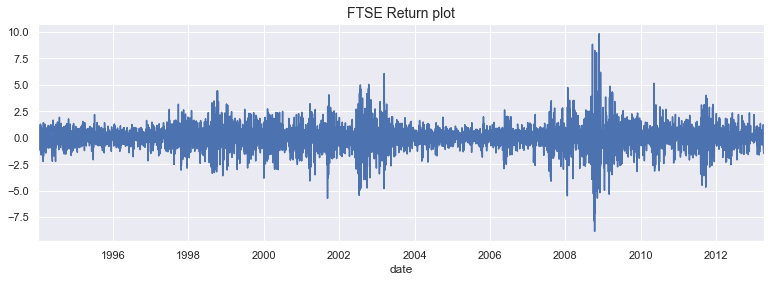

In [31]:
plt.figure(figsize=(13,4))
df_market_value_train.ret_ftse[1:].plot()
plt.title('FTSE Return plot',size=14)
plt.show()

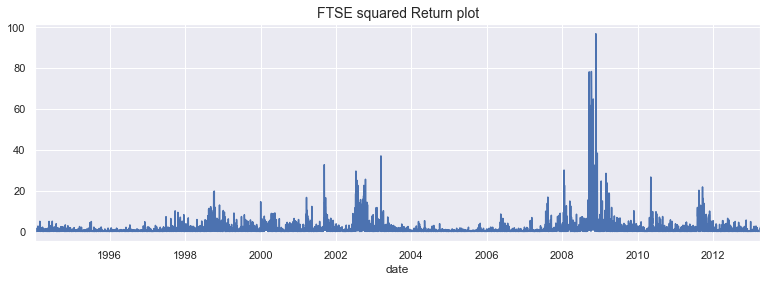

In [38]:
plt.figure(figsize=(13,4))
df_market_value_train.ret_ftse_sq[1:].plot()
plt.title('FTSE squared Return plot',size=14)
plt.show()

### PACF of return of ftse

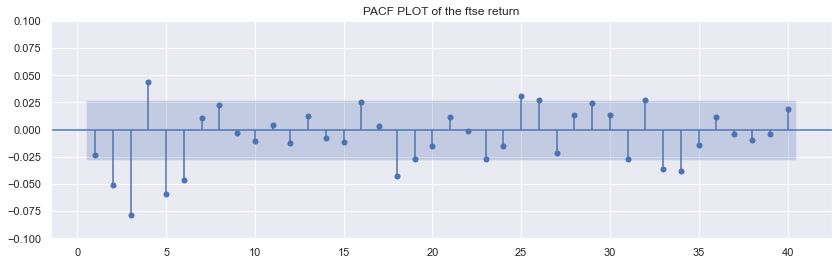

In [32]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['ret_ftse'][1:],alpha=0.05,method='ols',zero=False,lags=40)
plt.title("PACF PLOT of the ftse return",size=12)
plt.ylim((-0.1,0.1))
plt.show()

### PACF of squared return

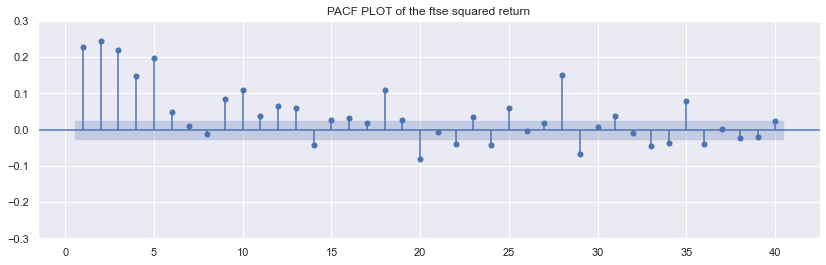

In [39]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['ret_ftse_sq'][1:],alpha=0.05,method='ols',zero=False,lags=40)
plt.title("PACF PLOT of the ftse squared return",size=12)
plt.ylim((-0.3,0.3))
plt.show()

#### ***Observation***
- By observing the pacf plot of the  ftse squared return it is clear that current return has strong correlatio with last 6th lags values.
- To make  more accurate ARCH model for prediction of volatility/conditional variance, we have to incoroparate past residuals. So to calculate no of lags for past residuals we can refered this pacf plot of square ftse return.
- It is also reasonable to do so cause if return is much more it followed by another much more return after one period, which can be evident from the square returned plot. and this unexpected spike of return cause volatility. So we can make accurate volatility model by incorporating this pacf result.

### Simple ARCH MODEL 

In [41]:
from arch import arch_model

In [45]:
model_garch_1=arch_model(df_market_value_train.ret_ftse[1:])
result_garch_1=model_garch_1.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 169566670380672.97
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2700794207.3567657
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7008.5167974778415
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7023.052470808224
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.310508812574
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.163507908772
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7117.006577414568
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.721816095447
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6969.917502984883
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6969.891799324589
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6969.891700336309
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6969.8916986339655
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6969.891698633552
Optimization terminated successfully    (Exit mode 0)
      

#### ***Observation***
- The output of fit function
- Iteration: it says total howmany interation required to converge.
- Neg.LLF  : notaion of log likelihood value of the model that has converged till that iteration.
- Since LLF value is negative here. So less is the LLF more is the model considered to be accurate.
- Converging process stops when absolute value of LLF value start increaseing.

In [46]:
print(result_arch_1.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6969.89
Distribution:                  Normal   AIC:                           13947.8
Method:            Maximum Likelihood   BIC:                           13973.9
                                        No. Observations:                 5020
Date:                Mon, Oct 28 2024   Df Residuals:                     5019
Time:                        17:34:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.193e-05 [2.

#### ***Observation***
- Here in this model we wanted to implement arch model but since we have implemented the simple with all default arguments, So this model is nothing but a GARCH model where it has considered a extra term called conditional variance obtained one term before to calculate current variance/volatility.More about Garch in next notebook.
- IN first section of table we can see that Mean model name is "Constant Mean".
- Volumn model name is : GARCH.
- Mehtod = maximum likelihood: this is the method which is used to compare each model evolved during the fitting process.
- R-squared and adj-squared value are used to measure how much variave are explained by model itself. and it is found out to be zero. it is also expected since. one constant constant can't explain a significant variance of output.
- Aic and Bic are the criterion to compare the model performance.
- one of the important part is Df value here that 1.
- Analysis of coefficients: all the coefficients are significant from zero.
- It has two section of coefficients one is for mu equation of arch model and an other section for volatility model.
- mu section has one coefficient value and that is for constant mu itself since default value of the arch model is that it will considered mu equaiton as constant.
- Volatility equation has three coefficients: one is the constant terms, another one is the coefficient of squared residuals obtained from last lag. and the third one is coefficient of volatility obtained till last period.

### Simple Arch(1) model.

In [51]:
model_arch_1=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=1)
result_arch_1=model_arch_1.fit()
print(result_arch_1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 28958.92039533578
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12049.595493091834
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7807.008869414005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7658.910854823742
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7658.91084489258
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7658.9108448926245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7658.91084489258
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7658.91
Distribution:                  Normal   AIC: 

### Observation
- We have just implemented a simple arch model by incorporating one residual obatined in last period.
- Distribution that is used to deal with residuals. Bascially best model will residual resembles with normal distribution. It is also default value since we have not specifically decided which residual distribution we should use.
- All the coefficient are significants and relyable.
- mu equation has considered to be constant, and its value is 0.0342.
- Log likelihood value found in the best model of arima is -7887.125 from which this simple arch model is better cause its llf is -7658.91. 

### NOTE:
- Arch model is used to predict future volatilty value only.

### EXAMINING THE HIGHER LAG

#### ***ARCH MODEL WITH ZERO MEAN EQAUTION***

In [50]:
model_arch_1_mu_zero=arch_model(df_market_value_train.ret_ftse[1:],mean='Zero',vol='ARCH',p=1)
result_arch_1_mu_zero=model_arch_1_mu_zero.fit()
print(result_arch_1_mu_zero.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11616.469981062515
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7812.164027401621
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7661.723992136859
Iteration:      4,   Func. Count:     18,   Neg. LLF: 7661.723985905119
Iteration:      5,   Func. Count:     20,   Neg. LLF: 7661.723985905144
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7661.723985905119
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
                        Zero Mean - ARCH Model Results                        
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7661.72
Distribution:                  Normal   AIC:                           15327.4
Method:            Maximum Likelihood

In [56]:
print(f"arch_p_1_mean_const:\t{result_arch_1.loglikelihood},\t Arch_p_1_mean_const:\t{result_arch_1.aic}")
print(f"arch_p_1_mean_zero:\t{result_arch_1_mu_zero.loglikelihood},\t Arch_p_1_mean_zero:\t{result_arch_1_mu_zero.aic}")


arch_p_1_mean_const:	-7658.91084489258,	 Arch_p_1_mean_const:	15323.82168978516
arch_p_1_mean_zero:	-7661.723985905119,	 Arch_p_1_mean_zero:	15327.447971810238


### observation
- The model with costant mean is performing better than model with zero mean.

#### ARCH model with constant mean, dist=t

In [58]:
model_arch_1_dist_t=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=1,dist='t')
result_arch_1_dist_t=model_arch_1_dist_t.fit()
print(result_arch_1_dist_t.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 166979.0198313926
Iteration:      2,   Func. Count:     15,   Neg. LLF: 78870.56371934162
Iteration:      3,   Func. Count:     21,   Neg. LLF: 11410.042867442215
Iteration:      4,   Func. Count:     27,   Neg. LLF: 10076.977185712076
Iteration:      5,   Func. Count:     33,   Neg. LLF: 11344.034027552847
Iteration:      6,   Func. Count:     39,   Neg. LLF: 7345.892618717092
Iteration:      7,   Func. Count:     44,   Neg. LLF: 7344.86887913607
Iteration:      8,   Func. Count:     49,   Neg. LLF: 7344.5967914521225
Iteration:      9,   Func. Count:     54,   Neg. LLF: 7344.549133363113
Iteration:     10,   Func. Count:     59,   Neg. LLF: 7344.541374841872
Iteration:     11,   Func. Count:     64,   Neg. LLF: 7344.5405771663145
Iteration:     12,   Func. Count:     69,   Neg. LLF: 7344.540568145871
Iteration:     13,   Func. Count:     73,   Neg. LLF: 7344.54056814586
Optimization terminated successfully    (Exit mode 0)
       

### ARCH WITH constant-mean and 'ged' distribution for residual

In [60]:
model_arch_1_dist_ged=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=1,dist='ged')
result_arch_1_dist_ged=model_arch_1_dist_ged.fit()
print(result_arch_1_dist_ged.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 963142474.9770554
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5950239.299905084
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7347.767302194946
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7593.159696904977
Iteration:      5,   Func. Count:     33,   Neg. LLF: 7697.831916313558
Iteration:      6,   Func. Count:     39,   Neg. LLF: 398891034.7006339
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7334.93107320773
Iteration:      8,   Func. Count:     51,   Neg. LLF: 7334.833211223495
Iteration:      9,   Func. Count:     56,   Neg. LLF: 7334.827699890471
Iteration:     10,   Func. Count:     61,   Neg. LLF: 7334.827468217485
Iteration:     11,   Func. Count:     66,   Neg. LLF: 7334.827406110852
Iteration:     12,   Func. Count:     71,   Neg. LLF: 7334.827341434735
Iteration:     13,   Func. Count:     76,   Neg. LLF: 7334.8276643195095
Iteration:     14,   Func. Count:     82,   Neg. LLF: 7334.82751

In [62]:
print(f"arch_p_1_mean_const_dist_norm LLF:\t{result_arch_1.loglikelihood},\t AIC:\t{result_arch_1.aic}")
print(f"arch_p_1_mean_const_dist_t    LLF:\t{result_arch_1_dist_t.loglikelihood},\t AIC:\t{result_arch_1_dist_t.aic}")
print(f"arch_p_1_mean_const_dist_ged  LLF:\t{result_arch_1_dist_ged.loglikelihood},\t AIC:\t{result_arch_1_dist_ged.aic}")


arch_p_1_mean_const_dist_norm LLF:	-7658.91084489258,	 AIC:	15323.82168978516
arch_p_1_mean_const_dist_t    LLF:	-7344.540568145871,	 AIC:	14697.081136291741
arch_p_1_mean_const_dist_ged  LLF:	-7334.827302505666,	 AIC:	14677.654605011332


#### ***Observation***
- From above experiment of ARCH Model with p=1 and mean is constant, it is observed that model with t and ged distribution for residual are better performing.

### Lets examine higher lag value of AR and volatile model.

## ARCH(2,dist='ged',vol='arch',mena='constant')

In [67]:
model_arch_2=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=2,dist='ged')
result_arch_2=model_arch_2.fit()
print(result_arch_2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 131248219.58882177
Iteration:      2,   Func. Count:     17,   Neg. LLF: 5953063.745110979
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7575.692347902126
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7409.860928036902
Iteration:      5,   Func. Count:     39,   Neg. LLF: 7307.856932913542
Iteration:      6,   Func. Count:     46,   Neg. LLF: 7578.367572471274
Iteration:      7,   Func. Count:     53,   Neg. LLF: 7312.765978628118
Iteration:      8,   Func. Count:     60,   Neg. LLF: 7412.3077630998305
Iteration:      9,   Func. Count:     67,   Neg. LLF: 7280.013373809708
Iteration:     10,   Func. Count:     74,   Neg. LLF: 7226.785543086444
Iteration:     11,   Func. Count:     80,   Neg. LLF: 7226.766062546667
Iteration:     12,   Func. Count:     86,   Neg. LLF: 7226.765560038284
Iteration:     13,   Func. Count:     92,   Neg. LLF: 7226.765542083751
Iteration:     14,   Func. Count:     97,   Neg. LLF: 7226.765

## ARCH(3,dist='ged',vol='arch',mena='constant')

In [68]:
model_arch_3=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=3,dist='ged')
result_arch_3=model_arch_3.fit()
print(result_arch_3.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 36507.251199918566
Iteration:      2,   Func. Count:     20,   Neg. LLF: 31893.03211849605
Iteration:      3,   Func. Count:     28,   Neg. LLF: 7464.140078979556
Iteration:      4,   Func. Count:     37,   Neg. LLF: 7464.560402077359
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7547.076399061341
Iteration:      6,   Func. Count:     53,   Neg. LLF: 7498.825307492663
Iteration:      7,   Func. Count:     62,   Neg. LLF: 7475.429658937122
Iteration:      8,   Func. Count:     70,   Neg. LLF: 7180.005930679026
Iteration:      9,   Func. Count:     78,   Neg. LLF: 7210.965501327637
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7137.6867839129345
Iteration:     11,   Func. Count:     93,   Neg. LLF: 7137.685304898897
Iteration:     12,   Func. Count:    100,   Neg. LLF: 7137.685299448891
Iteration:     13,   Func. Count:    106,   Neg. LLF: 7137.685299448831
Optimization terminated successfully    (Exit mode 0)
        

## ARCH(4,dist='ged',vol='arch',mena='constant')

In [69]:
model_arch_4=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=4,dist='ged')
result_arch_4=model_arch_4.fit()
print(result_arch_4.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 38235.988560817335
Iteration:      2,   Func. Count:     22,   Neg. LLF: 31116.81635353724
Iteration:      3,   Func. Count:     31,   Neg. LLF: 34939.5133084119
Iteration:      4,   Func. Count:     41,   Neg. LLF: 7376.858756087337
Iteration:      5,   Func. Count:     51,   Neg. LLF: 7414.833337535401
Iteration:      6,   Func. Count:     60,   Neg. LLF: 7716.366724435857
Iteration:      7,   Func. Count:     69,   Neg. LLF: 7479.572418722487
Iteration:      8,   Func. Count:     79,   Neg. LLF: 7465.339399260158
Iteration:      9,   Func. Count:     89,   Neg. LLF: 7142.168403264221
Iteration:     10,   Func. Count:     99,   Neg. LLF: 7232.675123214047
Iteration:     11,   Func. Count:    109,   Neg. LLF: 7078.396799167721
Iteration:     12,   Func. Count:    117,   Neg. LLF: 7078.385606509634
Iteration:     13,   Func. Count:    125,   Neg. LLF: 7078.385603502895
Iteration:     14,   Func. Count:    132,   Neg. LLF: 7078.38560

## ARCH(5,dist='ged',vol='arch',mena='constant')

In [70]:
model_arch_5=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=5,dist='ged')
result_arch_5=model_arch_5.fit()
print(result_arch_5.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 38026.77439650098
Iteration:      2,   Func. Count:     24,   Neg. LLF: 33329.68693459957
Iteration:      3,   Func. Count:     35,   Neg. LLF: 29221.97499905164
Iteration:      4,   Func. Count:     46,   Neg. LLF: 10074.112944554035
Iteration:      5,   Func. Count:     57,   Neg. LLF: 7359.5678505180185
Iteration:      6,   Func. Count:     68,   Neg. LLF: 7438.630389893578
Iteration:      7,   Func. Count:     79,   Neg. LLF: 7640.730877538257
Iteration:      8,   Func. Count:     90,   Neg. LLF: 7470.172788746049
Iteration:      9,   Func. Count:    101,   Neg. LLF: 7128.813972593754
Iteration:     10,   Func. Count:    112,   Neg. LLF: 7062.959060992399
Iteration:     11,   Func. Count:    122,   Neg. LLF: 7033.181530103462
Iteration:     12,   Func. Count:    132,   Neg. LLF: 7032.196062714036
Iteration:     13,   Func. Count:    141,   Neg. LLF: 7032.195733681141
Iteration:     14,   Func. Count:    150,   Neg. LLF: 7032.195

## ARCH(6,dist='ged',vol='arch',mena='constant')

In [71]:
model_arch_6=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=6,dist='ged')
result_arch_6=model_arch_6.fit()
print(result_arch_6.summary())

Iteration:      1,   Func. Count:     11,   Neg. LLF: 37482.51591808681
Iteration:      2,   Func. Count:     26,   Neg. LLF: 10448.6853195216
Iteration:      3,   Func. Count:     39,   Neg. LLF: 8063.513498394841
Iteration:      4,   Func. Count:     51,   Neg. LLF: 7570.153484008188
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7309.848028383386
Iteration:      6,   Func. Count:     74,   Neg. LLF: 7390.6587296387115
Iteration:      7,   Func. Count:     85,   Neg. LLF: 13979.387018444633
Iteration:      8,   Func. Count:     97,   Neg. LLF: 7228.540430235189
Iteration:      9,   Func. Count:    108,   Neg. LLF: 7170.9832364107115
Iteration:     10,   Func. Count:    120,   Neg. LLF: 7138.275276289502
Iteration:     11,   Func. Count:    132,   Neg. LLF: 7271.196140925891
Iteration:     12,   Func. Count:    144,   Neg. LLF: 7010.301594008943
Iteration:     13,   Func. Count:    156,   Neg. LLF: 7104.6921339535
Iteration:     14,   Func. Count:    168,   Neg. LLF: 6992.99805

## ARCH(7,dist='ged',vol='arch',mena='constant')

In [72]:
model_arch_7=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=7,dist='ged')
result_arch_7=model_arch_7.fit()
print(result_arch_7.summary())

Iteration:      1,   Func. Count:     12,   Neg. LLF: 38853.25871424066
Iteration:      2,   Func. Count:     28,   Neg. LLF: 28824.73488767303
Iteration:      3,   Func. Count:     41,   Neg. LLF: 15176.515920862781
Iteration:      4,   Func. Count:     54,   Neg. LLF: 7331.106686856279
Iteration:      5,   Func. Count:     66,   Neg. LLF: 9474.512042983639
Iteration:      6,   Func. Count:     80,   Neg. LLF: 213904.8367008696
Iteration:      7,   Func. Count:     93,   Neg. LLF: 7583.532827136898
Iteration:      8,   Func. Count:    106,   Neg. LLF: 7614.581501560991
Iteration:      9,   Func. Count:    119,   Neg. LLF: 7186.391873053775
Iteration:     10,   Func. Count:    132,   Neg. LLF: 7421.709919713517
Iteration:     11,   Func. Count:    145,   Neg. LLF: 7474.900169686927
Iteration:     12,   Func. Count:    158,   Neg. LLF: 7196.149117959787
Iteration:     13,   Func. Count:    171,   Neg. LLF: 6993.889906931357
Iteration:     14,   Func. Count:    183,   Neg. LLF: 6987.7565

## ARCH(8,dist='ged',vol='arch',mena='constant')

In [73]:
model_arch_8=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=8,dist='ged')
result_arch_8=model_arch_8.fit()
print(result_arch_8.summary())

Iteration:      1,   Func. Count:     13,   Neg. LLF: 38443.062160990405
Iteration:      2,   Func. Count:     30,   Neg. LLF: 29183.522466885064
Iteration:      3,   Func. Count:     44,   Neg. LLF: 12983.928611624591
Iteration:      4,   Func. Count:     58,   Neg. LLF: 34735.952159743276
Iteration:      5,   Func. Count:     72,   Neg. LLF: 10948.707528079649
Iteration:      6,   Func. Count:     86,   Neg. LLF: 12874.240526918602
Iteration:      7,   Func. Count:    100,   Neg. LLF: 9243.79164257744
Iteration:      8,   Func. Count:    114,   Neg. LLF: 7094.940648728101
Iteration:      9,   Func. Count:    128,   Neg. LLF: 7127.374633311632
Iteration:     10,   Func. Count:    141,   Neg. LLF: 7069.223160983613
Iteration:     11,   Func. Count:    155,   Neg. LLF: 7256.221086454462
Iteration:     12,   Func. Count:    169,   Neg. LLF: 7182.427110707915
Iteration:     13,   Func. Count:    183,   Neg. LLF: 6988.205804073514
Iteration:     14,   Func. Count:    197,   Neg. LLF: 7059.

## ARCH(9,dist='ged',vol='arch',mena='constant')

In [74]:
model_arch_9=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=9,dist='ged')
result_arch_9=model_arch_9.fit()
print(result_arch_9.summary())

Iteration:      1,   Func. Count:     14,   Neg. LLF: 37318.83163569622
Iteration:      2,   Func. Count:     32,   Neg. LLF: 10451.794619937524
Iteration:      3,   Func. Count:     48,   Neg. LLF: 8452.877035757476
Iteration:      4,   Func. Count:     63,   Neg. LLF: 7825.287133906699
Iteration:      5,   Func. Count:     78,   Neg. LLF: 7893.184374545942
Iteration:      6,   Func. Count:     93,   Neg. LLF: 1719456.484661877
Iteration:      7,   Func. Count:    108,   Neg. LLF: 8818.147302247886
Iteration:      8,   Func. Count:    123,   Neg. LLF: 7269.427256973832
Iteration:      9,   Func. Count:    137,   Neg. LLF: 7227.105618321535
Iteration:     10,   Func. Count:    152,   Neg. LLF: 7247.791981591928
Iteration:     11,   Func. Count:    166,   Neg. LLF: 7223.517346254104
Iteration:     12,   Func. Count:    181,   Neg. LLF: 7275.662048690601
Iteration:     13,   Func. Count:    196,   Neg. LLF: 7189.188093693969
Iteration:     14,   Func. Count:    211,   Neg. LLF: 7076.7906

## ARCH(10,dist='ged',vol='arch',mena='constant')

In [75]:
model_arch_10=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=10,dist='ged')
result_arch_10=model_arch_10.fit()
print(result_arch_10.summary())

Iteration:      1,   Func. Count:     15,   Neg. LLF: 36910.28421278885
Iteration:      2,   Func. Count:     34,   Neg. LLF: 10418.279834357203
Iteration:      3,   Func. Count:     51,   Neg. LLF: 8714.29449155536
Iteration:      4,   Func. Count:     67,   Neg. LLF: 7967.107122502128
Iteration:      5,   Func. Count:     83,   Neg. LLF: 7858.8364658015225
Iteration:      6,   Func. Count:     99,   Neg. LLF: 550483.7261094851
Iteration:      7,   Func. Count:    115,   Neg. LLF: 7501.490562462783
Iteration:      8,   Func. Count:    131,   Neg. LLF: 8112.477191775305
Iteration:      9,   Func. Count:    147,   Neg. LLF: 7259.2782735636265
Iteration:     10,   Func. Count:    163,   Neg. LLF: 7444.0651662564305
Iteration:     11,   Func. Count:    179,   Neg. LLF: 7577.556248992201
Iteration:     12,   Func. Count:    195,   Neg. LLF: 7366.136135533841
Iteration:     13,   Func. Count:    211,   Neg. LLF: 7236.086959063894
Iteration:     14,   Func. Count:    227,   Neg. LLF: 7114.12

## ARCH(11,dist='ged',vol='arch',mena='constant')

In [76]:
model_arch_11=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=11,dist='ged')
result_arch_11=model_arch_11.fit()
print(result_arch_11.summary())

Iteration:      1,   Func. Count:     16,   Neg. LLF: 37128.83874279591
Iteration:      2,   Func. Count:     36,   Neg. LLF: 28741.17416228588
Iteration:      3,   Func. Count:     53,   Neg. LLF: 7844.600929369334
Iteration:      4,   Func. Count:     71,   Neg. LLF: 9530.324879951593
Iteration:      5,   Func. Count:     88,   Neg. LLF: 637875.0163643379
Iteration:      6,   Func. Count:    105,   Neg. LLF: 7507.244897543303
Iteration:      7,   Func. Count:    122,   Neg. LLF: 7609.898251465498
Iteration:      8,   Func. Count:    139,   Neg. LLF: 7461.712424010169
Iteration:      9,   Func. Count:    156,   Neg. LLF: 7299.981513656145
Iteration:     10,   Func. Count:    173,   Neg. LLF: 7231.713114354061
Iteration:     11,   Func. Count:    190,   Neg. LLF: 7316.634974328397
Iteration:     12,   Func. Count:    207,   Neg. LLF: 7315.528145574233
Iteration:     13,   Func. Count:    224,   Neg. LLF: 7176.345755497396
Iteration:     14,   Func. Count:    241,   Neg. LLF: 7041.02198

## ARCH(12,dist='ged',vol='arch',mena='constant')

In [77]:
model_arch_12=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=12,dist='ged')
result_arch_12=model_arch_12.fit()
print(result_arch_12.summary())

Iteration:      1,   Func. Count:     17,   Neg. LLF: 37296.93776559593
Iteration:      2,   Func. Count:     38,   Neg. LLF: 28809.967007453473
Iteration:      3,   Func. Count:     56,   Neg. LLF: 63784.075131973135
Iteration:      4,   Func. Count:     74,   Neg. LLF: 9979.743603154933
Iteration:      5,   Func. Count:     92,   Neg. LLF: 7269.096260706994
Iteration:      6,   Func. Count:    110,   Neg. LLF: 9152.81091803491
Iteration:      7,   Func. Count:    127,   Neg. LLF: 8717.135610274749
Iteration:      8,   Func. Count:    145,   Neg. LLF: 11289.61585633505
Iteration:      9,   Func. Count:    163,   Neg. LLF: 7825.865885141295
Iteration:     10,   Func. Count:    181,   Neg. LLF: 7103.281834863625
Iteration:     11,   Func. Count:    199,   Neg. LLF: 7329.689336207166
Iteration:     12,   Func. Count:    217,   Neg. LLF: 7567.206275076553
Iteration:     13,   Func. Count:    235,   Neg. LLF: 7387.227546687138
Iteration:     14,   Func. Count:    253,   Neg. LLF: 7461.9952

## ARCH(13,dist='ged',vol='arch',mena='constant')

In [78]:
model_arch_13=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=13,dist='ged')
result_arch_13=model_arch_13.fit()
print(result_arch_13.summary())

Iteration:      1,   Func. Count:     18,   Neg. LLF: 36772.951685068605
Iteration:      2,   Func. Count:     40,   Neg. LLF: 33250.0863501345
Iteration:      3,   Func. Count:     58,   Neg. LLF: 73020.07397653032
Iteration:      4,   Func. Count:     76,   Neg. LLF: 68442.69731622392
Iteration:      5,   Func. Count:     95,   Neg. LLF: 7283.035029065648
Iteration:      6,   Func. Count:    114,   Neg. LLF: 8558.887360262448
Iteration:      7,   Func. Count:    133,   Neg. LLF: 9465.160013337414
Iteration:      8,   Func. Count:    152,   Neg. LLF: 8763.97632074289
Iteration:      9,   Func. Count:    171,   Neg. LLF: 8256.101686808488
Iteration:     10,   Func. Count:    190,   Neg. LLF: 11584.53718229194
Iteration:     11,   Func. Count:    209,   Neg. LLF: 17625.312447817334
Iteration:     12,   Func. Count:    228,   Neg. LLF: 7437.13746802965
Iteration:     13,   Func. Count:    247,   Neg. LLF: 7260.451799797246
Iteration:     14,   Func. Count:    266,   Neg. LLF: 7398.835058

## ARCH(14,dist='ged',vol='arch',mena='constant')

In [79]:
model_arch_14=arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol='ARCH',p=14,dist='ged')
result_arch_14=model_arch_14.fit()
print(result_arch_14.summary())

Iteration:      1,   Func. Count:     19,   Neg. LLF: 36688.552107463576
Iteration:      2,   Func. Count:     42,   Neg. LLF: 34005.699929770046
Iteration:      3,   Func. Count:     61,   Neg. LLF: 46083.35298320511
Iteration:      4,   Func. Count:     80,   Neg. LLF: 625031203463.7877
Iteration:      5,   Func. Count:    100,   Neg. LLF: 8057.843720459632
Iteration:      6,   Func. Count:    121,   Neg. LLF: 8322.81415638004
Iteration:      7,   Func. Count:    141,   Neg. LLF: 12343.741351078992
Iteration:      8,   Func. Count:    161,   Neg. LLF: 10525.475896480733
Iteration:      9,   Func. Count:    181,   Neg. LLF: 8431.468175705368
Iteration:     10,   Func. Count:    201,   Neg. LLF: 8057.4849943861245
Iteration:     11,   Func. Count:    221,   Neg. LLF: 8091.9572296540655
Iteration:     12,   Func. Count:    241,   Neg. LLF: 7347.598731092212
Iteration:     13,   Func. Count:    261,   Neg. LLF: 7455.281248861546
Iteration:     14,   Func. Count:    281,   Neg. LLF: 7244.

#### Observation
- By observing all the garch model with all the residual value present at different lag, it is clear that the model with higher lag residual are more accurate in terms log likelihood.
- Talking about coefficient: the model which have considerd higher lag of 13 or more are likely to have insignificant coefficients. even though upto lag 12 log-likelihood value is increaseing.
- So the arch model with highest lag of 12 for volatility model, one for mu model and residual distribution 'ged' has performed best among the others.
- best log likelihood obtained by arch-12 is -6944.45

### ARCH model with higher AR lags

### ARCH(df,mean='AR',lags=[1],vol='arch',p=12,dist='ged')

In [82]:
model_arch_p12_mean_lag1_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag1_dist_ged=model_arch_p12_mean_lag1_dist_ged_.fit()
print(result_arch_p12_mean_lag1_dist_ged.summary())

Iteration:      1,   Func. Count:     18,   Neg. LLF: 37807.10737109279
Iteration:      2,   Func. Count:     40,   Neg. LLF: 21617.021129944333
Iteration:      3,   Func. Count:     61,   Neg. LLF: 10859.794847593426
Iteration:      4,   Func. Count:     79,   Neg. LLF: 60087190779718.69
Iteration:      5,   Func. Count:     98,   Neg. LLF: 7950.835762230541
Iteration:      6,   Func. Count:    117,   Neg. LLF: 9352.811322785246
Iteration:      7,   Func. Count:    136,   Neg. LLF: 8593.063453209426
Iteration:      8,   Func. Count:    155,   Neg. LLF: 8812.920780791668
Iteration:      9,   Func. Count:    174,   Neg. LLF: 8010.423337845056
Iteration:     10,   Func. Count:    193,   Neg. LLF: 7263.232332794441
Iteration:     11,   Func. Count:    212,   Neg. LLF: 7716.204299276735
Iteration:     12,   Func. Count:    231,   Neg. LLF: 7257.723431310771
Iteration:     13,   Func. Count:    250,   Neg. LLF: 7317.0466193328575
Iteration:     14,   Func. Count:    269,   Neg. LLF: 7254.06

### ARCH(df,mean='AR',lags=[1,2],vol='arch',p=12,dist='ged')

In [83]:
model_arch_p12_mean_lag2_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag2_dist_ged=model_arch_p12_mean_lag2_dist_ged_.fit()
print(result_arch_p12_mean_lag2_dist_ged.summary())

Iteration:      1,   Func. Count:     19,   Neg. LLF: 78686.08455729947
Iteration:      2,   Func. Count:     42,   Neg. LLF: 70453.68364926931
Iteration:      3,   Func. Count:     64,   Neg. LLF: 31342.12743126158
Iteration:      4,   Func. Count:     84,   Neg. LLF: 13739.89829518998
Iteration:      5,   Func. Count:    104,   Neg. LLF: 7408.61011597742
Iteration:      6,   Func. Count:    124,   Neg. LLF: 2301498420.2295375
Iteration:      7,   Func. Count:    144,   Neg. LLF: 8562.932750877582
Iteration:      8,   Func. Count:    163,   Neg. LLF: 15479.58400106434
Iteration:      9,   Func. Count:    183,   Neg. LLF: 56135.31836382707
Iteration:     10,   Func. Count:    203,   Neg. LLF: 7685.099175421866
Iteration:     11,   Func. Count:    223,   Neg. LLF: 7530.805349611276
Iteration:     12,   Func. Count:    243,   Neg. LLF: 7288.982912207914
Iteration:     13,   Func. Count:    263,   Neg. LLF: 7348.648170801357
Iteration:     14,   Func. Count:    283,   Neg. LLF: 7160.70452

### ARCH(df,mean='AR',lags=[1,2,3],vol='arch',p=12,dist='ged')

In [85]:
model_arch_p12_mean_lag3_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2,3],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag3_dist_ged=model_arch_p12_mean_lag3_dist_ged_.fit()
print(result_arch_p12_mean_lag3_dist_ged.summary())

Iteration:      1,   Func. Count:     20,   Neg. LLF: 37169941.27909248
Iteration:      2,   Func. Count:     44,   Neg. LLF: 60689.525849116384
Iteration:      3,   Func. Count:     67,   Neg. LLF: 44384.989709991656
Iteration:      4,   Func. Count:     89,   Neg. LLF: 42185.88779502901
Iteration:      5,   Func. Count:    110,   Neg. LLF: 14485.852404265168
Iteration:      6,   Func. Count:    131,   Neg. LLF: 8308.062325718347
Iteration:      7,   Func. Count:    152,   Neg. LLF: 6854888115547.6455
Iteration:      8,   Func. Count:    173,   Neg. LLF: 8056.293206428434
Iteration:      9,   Func. Count:    194,   Neg. LLF: 9597.180485554018
Iteration:     10,   Func. Count:    215,   Neg. LLF: 9422.362495037261
Iteration:     11,   Func. Count:    236,   Neg. LLF: 9890.467972540606
Iteration:     12,   Func. Count:    257,   Neg. LLF: 8923.892832786107
Iteration:     13,   Func. Count:    278,   Neg. LLF: 7287.195820664317
Iteration:     14,   Func. Count:    299,   Neg. LLF: 7399.6

### ARCH(df,mean='AR',lags=[1,2,3,4],vol='arch',p=12,dist='ged')

In [88]:
model_arch_p12_mean_lag4_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2,3,4],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag4_dist_ged=model_arch_p12_mean_lag4_dist_ged_.fit()
print(result_arch_p12_mean_lag1_dist_ged.summary())

Iteration:      1,   Func. Count:     21,   Neg. LLF: 5.611832309856435e+21
Iteration:      2,   Func. Count:     46,   Neg. LLF: 63074.45141897586
Iteration:      3,   Func. Count:     70,   Neg. LLF: 38915.596684903074
Iteration:      4,   Func. Count:     93,   Neg. LLF: 41854.02455878208
Iteration:      5,   Func. Count:    115,   Neg. LLF: 37448.0205769983
Iteration:      6,   Func. Count:    137,   Neg. LLF: 8981.821915964625
Iteration:      7,   Func. Count:    159,   Neg. LLF: 22275706.453934096
Iteration:      8,   Func. Count:    182,   Neg. LLF: 5.815322045014158e+37
Iteration:      9,   Func. Count:    205,   Neg. LLF: 8012.371654072045
Iteration:     10,   Func. Count:    227,   Neg. LLF: 11578.824944256583
Iteration:     11,   Func. Count:    249,   Neg. LLF: 24522.717216868987
Iteration:     12,   Func. Count:    271,   Neg. LLF: 12945.360685400887
Iteration:     13,   Func. Count:    293,   Neg. LLF: 9199.26412827991
Iteration:     14,   Func. Count:    315,   Neg. LLF:

In [87]:
model_arch_p12_mean_lag5_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2,3,4,5],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag5_dist_ged=model_arch_p12_mean_lag5_dist_ged_.fit()
print(result_arch_p12_mean_lag5_dist_ged.summary())

Iteration:      1,   Func. Count:     22,   Neg. LLF: 5.451492692431332e+28
Iteration:      2,   Func. Count:     48,   Neg. LLF: 63477.66389965017
Iteration:      3,   Func. Count:     73,   Neg. LLF: 43318.41441569416
Iteration:      4,   Func. Count:     97,   Neg. LLF: 42080.52304739991
Iteration:      5,   Func. Count:    120,   Neg. LLF: 35958.868560377465
Iteration:      6,   Func. Count:    143,   Neg. LLF: 12543.569441195294
Iteration:      7,   Func. Count:    166,   Neg. LLF: 7876.4584818746025
Iteration:      8,   Func. Count:    189,   Neg. LLF: 1.383107478306834e+24
Iteration:      9,   Func. Count:    213,   Neg. LLF: 8.63129383084719e+44
Iteration:     10,   Func. Count:    237,   Neg. LLF: 17697.610109095578
Iteration:     11,   Func. Count:    260,   Neg. LLF: 13338.307938170328
Iteration:     12,   Func. Count:    283,   Neg. LLF: 15541.921761463022
Iteration:     13,   Func. Count:    306,   Neg. LLF: 13832.157945908246
Iteration:     14,   Func. Count:    329,   Ne

In [89]:
model_arch_p12_mean_lag6_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2,3,4,5,6],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag6_dist_ged=model_arch_p12_mean_lag6_dist_ged_.fit()
print(result_arch_p12_mean_lag6_dist_ged.summary())

Iteration:      1,   Func. Count:     23,   Neg. LLF: 3.7116574093287387e+30
Iteration:      2,   Func. Count:     50,   Neg. LLF: 71867.37805665514
Iteration:      3,   Func. Count:     76,   Neg. LLF: 46174.487833906576
Iteration:      4,   Func. Count:    101,   Neg. LLF: 33949.706440119684
Iteration:      5,   Func. Count:    125,   Neg. LLF: 44710.47925313405
Iteration:      6,   Func. Count:    149,   Neg. LLF: 15170.153405595385
Iteration:      7,   Func. Count:    173,   Neg. LLF: 7688.844280816125
Iteration:      8,   Func. Count:    197,   Neg. LLF: 338525099.8077971
Iteration:      9,   Func. Count:    222,   Neg. LLF: 4.581020236988988e+33
Iteration:     10,   Func. Count:    247,   Neg. LLF: 108830.44853066691
Iteration:     11,   Func. Count:    272,   Neg. LLF: 13466.834216487317
Iteration:     12,   Func. Count:    296,   Neg. LLF: 64026.20388333441
Iteration:     13,   Func. Count:    320,   Neg. LLF: 32581.151030145265
Iteration:     14,   Func. Count:    344,   Neg. 

In [91]:
model_arch_p12_mean_lag7_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1,2,3,4,5,6,7],vol='ARCH',p=12,dist='ged')
result_arch_p12_mean_lag7_dist_ged=model_arch_p12_mean_lag7_dist_ged_.fit()
print(result_arch_p12_mean_lag7_dist_ged.summary())

Iteration:      1,   Func. Count:     24,   Neg. LLF: 1.877312657456594e+28
Iteration:      2,   Func. Count:     52,   Neg. LLF: 62698.18295663489
Iteration:      3,   Func. Count:     79,   Neg. LLF: 51262.20732995504
Iteration:      4,   Func. Count:    105,   Neg. LLF: 34820.45450934071
Iteration:      5,   Func. Count:    130,   Neg. LLF: 38144.85657461274
Iteration:      6,   Func. Count:    155,   Neg. LLF: 16176.62643353903
Iteration:      7,   Func. Count:    180,   Neg. LLF: 7789.280453100393
Iteration:      8,   Func. Count:    205,   Neg. LLF: 188772.96620264545
Iteration:      9,   Func. Count:    231,   Neg. LLF: 1.5193558022383219e+19
Iteration:     10,   Func. Count:    257,   Neg. LLF: 39641.037737669016
Iteration:     11,   Func. Count:    283,   Neg. LLF: 13525.261673325876
Iteration:     12,   Func. Count:    308,   Neg. LLF: 16014.735945578006
Iteration:     13,   Func. Count:    333,   Neg. LLF: 409690.70644553786
Iteration:     14,   Func. Count:    358,   Neg. L

### Observation
- From the above experiments it is observed that none of the ARCH MODEL with p value 12 and higher lags value of more than 1, has all significant coefficients, eventhough  with adding values of past period is increaseing the log likelihood values.
- But still these model are reliable for its insignificant nature of some coefficients.
- And eventhough adding more past values are increaseing complexity of the model but not increaseing log likelihood significantly. so we will reject this model.

## Lets check if keeping the value of lags for AR part to 1 and decreaseing the lags of volatility model will increase significance of the coefficients and increase log likelihood.
- given that highest log likelihood value observed in a consistent model observed so far is -6944
- So we have to find a better model with higher log likelihood value

## ARCH(df,dist='ged',p=11,mean='AR',lags=[1],vol='ARCH')

In [94]:
model_arch_p11_mean_lag1_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1],vol='ARCH',p=11,dist='ged')
result_arch_p11_mean_lag1_dist_ged=model_arch_p11_mean_lag1_dist_ged_.fit()
print(result_arch_p11_mean_lag1_dist_ged.summary())

Iteration:      1,   Func. Count:     17,   Neg. LLF: 38476.38953101533
Iteration:      2,   Func. Count:     38,   Neg. LLF: 40686.90489011927
Iteration:      3,   Func. Count:     57,   Neg. LLF: 46152.99616419793
Iteration:      4,   Func. Count:     75,   Neg. LLF: 7555.398154691727
Iteration:      5,   Func. Count:     93,   Neg. LLF: 13808.30098162661
Iteration:      6,   Func. Count:    110,   Neg. LLF: 408790235.32893515
Iteration:      7,   Func. Count:    128,   Neg. LLF: 7994.232791376277
Iteration:      8,   Func. Count:    146,   Neg. LLF: 7823.315192862401
Iteration:      9,   Func. Count:    164,   Neg. LLF: 7942.231947829069
Iteration:     10,   Func. Count:    182,   Neg. LLF: 7485.771525420851
Iteration:     11,   Func. Count:    200,   Neg. LLF: 8890.420809687315
Iteration:     12,   Func. Count:    218,   Neg. LLF: 7748.404887374332
Iteration:     13,   Func. Count:    236,   Neg. LLF: 7285.16095409864
Iteration:     14,   Func. Count:    254,   Neg. LLF: 7637.77015

In [93]:
model_arch_p10_mean_lag1_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1],vol='ARCH',p=10,dist='ged')
result_arch_p10_mean_lag1_dist_ged=model_arch_p10_mean_lag1_dist_ged_.fit()
print(result_arch_p10_mean_lag1_dist_ged.summary())

Iteration:      1,   Func. Count:     16,   Neg. LLF: 38057.3966639527
Iteration:      2,   Func. Count:     36,   Neg. LLF: 17259.090821802034
Iteration:      3,   Func. Count:     54,   Neg. LLF: 23352.46392563603
Iteration:      4,   Func. Count:     73,   Neg. LLF: 8796.02202241369
Iteration:      5,   Func. Count:     90,   Neg. LLF: 7961.615566548131
Iteration:      6,   Func. Count:    107,   Neg. LLF: 7863.898940231177
Iteration:      7,   Func. Count:    124,   Neg. LLF: 855777.728338789
Iteration:      8,   Func. Count:    141,   Neg. LLF: 7445.632276174324
Iteration:      9,   Func. Count:    158,   Neg. LLF: 7698.991154900081
Iteration:     10,   Func. Count:    175,   Neg. LLF: 7156.627627886536
Iteration:     11,   Func. Count:    192,   Neg. LLF: 7348.05181588725
Iteration:     12,   Func. Count:    209,   Neg. LLF: 7311.8881550364895
Iteration:     13,   Func. Count:    226,   Neg. LLF: 7119.341085372062
Iteration:     14,   Func. Count:    242,   Neg. LLF: 7074.4602439

In [95]:
model_arch_p1_mean_lag1_dist_ged_=arch_model(df_market_value_train.ret_ftse[1:],mean='AR',lags=[1],vol='ARCH',p=1,dist='ged')
result_arch_p1_mean_lag1_dist_ged=model_arch_p1_mean_lag1_dist_ged_.fit()
print(result_arch_p1_mean_lag1_dist_ged.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 252222807.17069402
Iteration:      2,   Func. Count:     17,   Neg. LLF: 24602451.10447187
Iteration:      3,   Func. Count:     26,   Neg. LLF: 6004192.5390031785
Iteration:      4,   Func. Count:     33,   Neg. LLF: 7469.873826209805
Iteration:      5,   Func. Count:     40,   Neg. LLF: 7602.598493267679
Iteration:      6,   Func. Count:     48,   Neg. LLF: 7378.758685666817
Iteration:      7,   Func. Count:     55,   Neg. LLF: 7342.077583986014
Iteration:      8,   Func. Count:     62,   Neg. LLF: 7339.134787592804
Iteration:      9,   Func. Count:     69,   Neg. LLF: 7340.402339268343
Iteration:     10,   Func. Count:     76,   Neg. LLF: 7333.778454798144
Iteration:     11,   Func. Count:     82,   Neg. LLF: 7333.741820639192
Iteration:     12,   Func. Count:     88,   Neg. LLF: 7333.740429090578
Iteration:     13,   Func. Count:     94,   Neg. LLF: 7333.740212934723
Iteration:     14,   Func. Count:    100,   Neg. LLF: 7333.740

#### ***Observation***
- by decreaseing the value of p by keeping the lags value of AR 1 , It is observed that decreaseing the p value dominating log likelihood value more than it is increased by keeping AR Lag term 1. It is also observed that the value of coefficients of AR component is still insignificant from zero.
- So these model are not reliable.
#### conclusion arch model
- So far the best model observed till now is ARCH(df, p=12,mean='Constant',dist='ged',vol='arch')
- Best loglikelihood found so far is -6944

## GARCH
- GARCH is the extended version of the ARCH.
- As we have observed from the above experiments that after certain no of residual lags the model started become inconsistent because of insignificant nature of the coefficients.
- And it was even becoming more insignificant when we add first past value of last period for AR Model.
- But since we are dealing with residual here which will resemble with normal ma model. and we have observed that when ma model was not working well by adding past residual, we came with the idea to add past values. and this idea was working well. similarly we will add past volatilty value in to equation of volatility model to make more accurate model. here the past volatilty value is the only volatilty value observed in last period. after adding this we dont need add any further period volatilty value since all the past volatilty value are arealy incorporated in the last period.
- Vol(t)^2 = C0 + C1 * Epsion(t-1)^2 + C3 * Vol(t-1)^2 : conditional volatilty model.
- C1: alpha
- C2: Beta
- This whole model dentoed by GARCH(p,q). where p is arch order: (no of residuals from past period) and q is no of garch order(no of conditional volatility in last period)
- usually value of q is 1 only

## GARCH(1,1)
- Fitting uncorrelated data into Garch
- uncorrelated data: it means that mean equation does not rely on past values.

In [99]:
model_garch_1_1= arch_model(df_market_value_train.ret_ftse[1:],mean='Constant',vol="GARCH",p=1,q=1,dist='ged')
result_garch_1_1= model_garch_1_1.fit(update_freq=5)
print(result_garch_1_1.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 6988.840929345403
Iteration:     10,   Func. Count:     77,   Neg. LLF: 6930.179945907892
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6930.158940035488
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 13
                           Constant Mean - GARCH Model Results                            
Dep. Variable:                           ret_ftse   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -6930.16
Distribution:      Generalized Error Distribution   AIC:                           13870.3
Method:                        Maximum Likelihood   BIC:                           13902.9
                                                    No. Observations:                 5020
Date:     

### Observation
- As we can see adding past value in volatility model increases the log likelihood of garch model so well that its loglikelihood value is better than normal arch model with 12 past residual values taken into the consideration. which is very significant improvement with only one added term.
- So this model is the best model found so far.
- best loglikelihood -6930

### GARCH MODEL with higher lags
- It is mathmetically proven that model with higher lag than GARCH(1,1), wont perform well in compared to GARCH(1,1). cause the coefficient of those modle become very inconsistent.
- the reason behind this is that since we have added variance value obtained in last period in the model which incorporated all the past variance in iteself. So adding a extra residual or past variance will make this whole model more inconsitent.

# conclusion
- best model found so far to predict the ftse return index is arch_model(df.return, dist='ged',p=1,q=1,mean='Constant',vol='GARCH').
- Asociated log likelihood is -6930.